In [1]:
import numpy as np
import cv2
import matplotlib.mlab as mlab 
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

In [2]:
print("OpenCV version {}".format(cv2.__version__))
print("numpy version {}".format(np.__version__))

OpenCV version 4.4.0
numpy version 1.19.4


In [3]:
base = "/Users/yiyiwang/Desktop/Graduate/code/HTP-LSNS/"
print(base)

/Users/yiyiwang/Desktop/Graduate/code/HTP-LSNS/


In [4]:
# set filenames to read
obj_names_file = base + "obj.names"
yolov3_weight_file = base + "yolov3_training_last.weights"
yolov3_config_file = base + "yolov3_testing.cfg"

# read object names
LABELS = open(obj_names_file).read().strip().split("\n")

# assign rondom colours to the corresponding class labels
np.random.seed(45)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

# read YOLO network model
net = cv2.dnn.readNetFromDarknet(yolov3_config_file, yolov3_weight_file)

In [5]:
# read image file
# image is an array of image data (row, column, channel)
images_base = "/Users/yiyiwang/Desktop/data/test/risk/"
fileName = images_base + '9.jpg'
image = cv2.imread(images_base+"15.jpg")

(h, w) = image.shape[:2]

# preprocess image data with rescaling and resizing
# OpenCV assumes BGR images: we have to convert to RGB, with swapRB=True
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# set a new input to the network
net.setInput(blob)

In [6]:
# print the information of layers in YOLO v3 model

# get all layer names in the network
ln = net.getLayerNames()
print("--- Layers in YOLO v3 ---")
print(ln)
print("--- {} layers ---".format(len(ln)))

# this is indices of layers with unconnected output
print("\nIndices of YOLO v3 output layers = \n{}".format(net.getUnconnectedOutLayers()))

# get layers only with unconnected output
ln_out = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
print("Names of YOLO v3 output layers = {}".format(ln_out))

--- Layers in YOLO v3 ---
['conv_0', 'bn_0', 'relu_1', 'conv_1', 'bn_1', 'relu_2', 'conv_2', 'bn_2', 'relu_3', 'conv_3', 'bn_3', 'relu_4', 'shortcut_4', 'conv_5', 'bn_5', 'relu_6', 'conv_6', 'bn_6', 'relu_7', 'conv_7', 'bn_7', 'relu_8', 'shortcut_8', 'conv_9', 'bn_9', 'relu_10', 'conv_10', 'bn_10', 'relu_11', 'shortcut_11', 'conv_12', 'bn_12', 'relu_13', 'conv_13', 'bn_13', 'relu_14', 'conv_14', 'bn_14', 'relu_15', 'shortcut_15', 'conv_16', 'bn_16', 'relu_17', 'conv_17', 'bn_17', 'relu_18', 'shortcut_18', 'conv_19', 'bn_19', 'relu_20', 'conv_20', 'bn_20', 'relu_21', 'shortcut_21', 'conv_22', 'bn_22', 'relu_23', 'conv_23', 'bn_23', 'relu_24', 'shortcut_24', 'conv_25', 'bn_25', 'relu_26', 'conv_26', 'bn_26', 'relu_27', 'shortcut_27', 'conv_28', 'bn_28', 'relu_29', 'conv_29', 'bn_29', 'relu_30', 'shortcut_30', 'conv_31', 'bn_31', 'relu_32', 'conv_32', 'bn_32', 'relu_33', 'shortcut_33', 'conv_34', 'bn_34', 'relu_35', 'conv_35', 'bn_35', 'relu_36', 'shortcut_36', 'conv_37', 'bn_37', 'relu_3

In [7]:
# perform object detection
layerOutputs = net.forward(ln_out)

In [8]:
# print the shape of output
print(np.array(layerOutputs)[0].shape)
print(np.array(layerOutputs)[1].shape)
print(np.array(layerOutputs)[2].shape)
print(layerOutputs[0])

(507, 16)
(2028, 16)
(8112, 16)
[[0.04316197 0.0474738  0.3406685  ... 0.         0.         0.        ]
 [0.05096836 0.03861529 0.30832916 ... 0.         0.         0.        ]
 [0.04099222 0.0496586  1.591017   ... 0.         0.         0.        ]
 ...
 [0.94216317 0.9532243  0.33689368 ... 0.         0.         0.        ]
 [0.955796   0.960412   0.2904714  ... 0.         0.         0.        ]
 [0.958395   0.9611019  1.0062022  ... 0.         0.         0.        ]]


<ipython-input-8-aa0284d78b29>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(layerOutputs)[0].shape)
<ipython-input-8-aa0284d78b29>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(layerOutputs)[1].shape)
<ipython-input-8-aa0284d78b29>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(laye

In [9]:
# Filter objects with the lower (box confidence * class prediction probability) than the threshold

threshold = 0.5

boxes = []
scores = []
classes = []

for output in layerOutputs:

    box_xywh = np.array(output[:, :4])
    box_confidence = np.array(output[:, 4]).reshape(output.shape[0], 1)
    box_class_probs = np.array(output[:, 5:])
    
    #print("box_xywh = {}".format(box_xywh[0]))
    #print("box_confidence = {}".format(np.squeeze(box_confidence, axis=1)))
    
    box_scores = box_confidence * box_class_probs
    box_class = np.argmax(box_scores, axis=-1)
    box_class_scores = np.max(box_scores, axis=-1)
    #print("box_confidence = {}, box_class = {}, box_class_scores = {}, box_class_probs={}".format(box_confidence[289],
    #                                                                          box_class[289], box_class_scores[289],
    #                                                                            box_class_probs[289]))
    
    # pick up boxes with box_class_scores which are higher than threshold
    filtering_mask = box_class_scores >= threshold
    #filtering_mask = np.squeeze(box_confidence, axis=1)  >= threshold
    class_filtered = box_class[filtering_mask]
    score_filtered = box_class_scores[filtering_mask]
    xywh_filtered = box_xywh[np.nonzero(filtering_mask)]

    #print("class_filtered = {}".format(class_filtered))
    #print("score_filtered = {}".format(score_filtered))
    #print("xywh_filtered = {}".format(xywh_filtered))
    #print("filtering_mask = {}, len={}".format(filtering_mask, len(filtering_mask)))
    
    boxes.append(xywh_filtered)
    scores.append(score_filtered)
    classes.append(class_filtered)


# Change shapes of arrays so that all boxes from any output layers are stored together
boxes = np.vstack([r for r in boxes])
print("boxes = {}".format(boxes))
scores = np.concatenate([r for r in scores], axis=None)
print("scores = {}".format(scores))
classes = np.concatenate([r for r in classes], axis=None)
print("classes = {}".format(classes))
print([LABELS[c] for c in classes])


boxes = [[0.61130935 0.4337189  0.43214288 0.8810515 ]
 [0.62348884 0.43599892 0.40412313 0.8493774 ]
 [0.5018174  0.60928375 0.57113844 0.47886556]
 [0.50182116 0.6236094  0.51427495 0.5287632 ]
 [0.51657414 0.56556374 0.13829532 0.18505827]
 [0.52121824 0.5673593  0.14078198 0.19053687]
 [0.32977152 0.687506   0.11764951 0.21921499]
 [0.3300675  0.6940995  0.1278378  0.22000955]
 [0.5371636  0.7119332  0.12412894 0.17057122]
 [0.5439145  0.7149642  0.12974206 0.1488902 ]
 [0.54296166 0.7155987  0.11939987 0.14665985]]
scores = [0.9515692 0.924859  0.9793265 0.9900208 0.5033289 0.99506   0.9992811
 0.9849354 0.8743616 0.9885458 0.9861852]
classes = [7 7 8 8 0 0 4 4 6 6 6]
['Tree_1', 'Tree_1', 'House_1', 'House_1', 'Window with curtain_1', 'Window with curtain_1', 'Door with Handler_2', 'Door with Handler_2', 'Person_1', 'Person_1', 'Person_1']


In [10]:
# rescale bounding boxes so that they fit the original image
print("h, w = {}, {}".format(h, w))
boxes = boxes * np.array([w, h, w, h])
#print(boxes)
boxes[:, 0] -= boxes[:, 2] / 2
boxes[:, 1] -= boxes[:, 3] / 2

h, w = 2208, 2553


In [11]:
# make an array of box coordinates.
# boxes_coord = array of [[x1, y1, x2, y2], ...]: where (x1, y1) = upper left, (x2, y2) = lower right
boxes_coord = boxes
# set x2 = x1 + w
boxes_coord[:, 2] = boxes[:, 0] + boxes[:, 2]
# set y2 = y1 + h
boxes_coord[:, 3] = boxes[:, 1] + boxes[:, 3]

# cv2.dnn.NMSBoxes() doesn't work; when I run the code below, the kernel dies.
#indices = cv2.dnn.NMSBoxes(boxes, scores, threshold, iou_threshold)

In [12]:
def iou(box1, box2):
    """ Caculate IoU between box1 and box2
        box1/box2 : (x1, y1, x2, y2), where x1 and y1 are coordinates of upper left corner, 
                    x2 and y2 are of lower right corner
        return: IoU
    """
    
    # get the area of intersection 
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])

    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)
    
    # get the area of union
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - inter_area
    
    # get iou
    iou = inter_area / union_area
    
    return iou

In [13]:
def yolo_non_max_supression(boxes, scores, score_threshold=0.5, iou_threshould=0.5):
    """ Apply Non-max supression.
        boxes : Array of coordinates of boxes (x1, y1, x2, y2)
        scores : Array of confidence scores with respect to boxes
        score_threshold : Threshold of the score to keep
        iou_threshold : Threshold of IoU to keep 
        
        Return : Indices of boxes and scores to be kept
    """
    
    sorted_idx = np.argsort(scores)[::-1]
    print(sorted_idx)
    
    remove = []
    for i in np.arange(len(scores)):
        if i in remove:
            continue
        if scores[sorted_idx[i]] < score_threshold:
            remove.append(i)
            continue
            
        for j in np.arange(i+1, len(scores)):
            if scores[sorted_idx[j]] < score_threshold:
                remove.append(j)
                continue
                
            overlap = iou(boxes[sorted_idx[i]], boxes[sorted_idx[j]])
            if overlap > iou_threshould:
                remove.append(j)
                
    sorted_idx = np.delete(sorted_idx, remove)
    return sorted(sorted_idx)

In [14]:
sorted_idx = np.argsort(scores)[::-1]
print(sorted_idx)

[ 6  5  3  9 10  7  2  0  1  8  4]


In [15]:
# Apply Non-max supression
nms_idx = yolo_non_max_supression(boxes_coord, scores, score_threshold=threshold)
print(nms_idx)

[ 6  5  3  9 10  7  2  0  1  8  4]
[0, 3, 5, 6, 9]


[7 8 0 4 6]


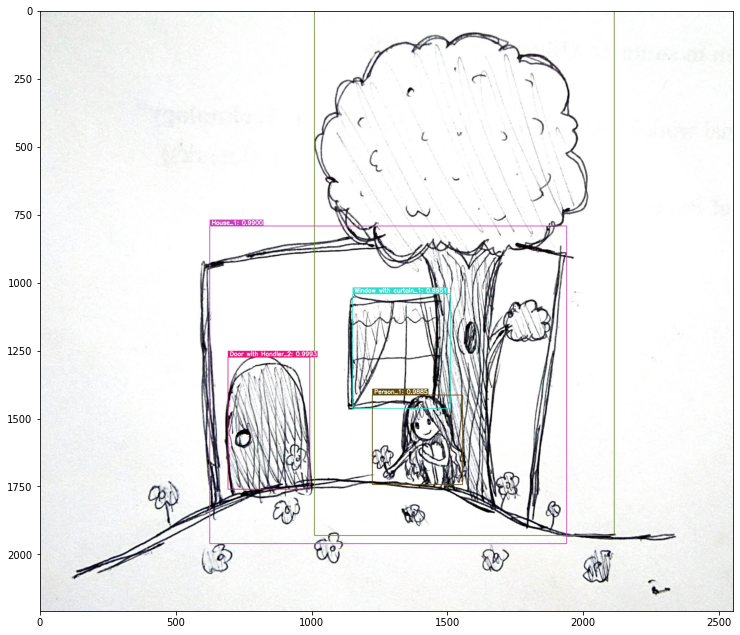

['Tree_1: 0.9516', 'House_1: 0.9900', 'Window with curtain_1: 0.9951', 'Door with Handler_2: 0.9993', 'Person_1: 0.9885']


In [16]:
print(classes[nms_idx])

# Draw bounding boxes on the image and show

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
border_thickness = 2
text_thickness = 2

text_all = []
for box in nms_idx:
    color = tuple([int(c) for c in COLORS[classes[box]]])
    #print(color)
    text = "{}: {:.4f}".format(LABELS[classes[box]], scores[box])
    #print(text)
    text_all.append(text)
    
    (pt1_x, pt1_y) = (int(boxes_coord[box, 0]), int(boxes_coord[box, 1]))
    (pt2_x, pt2_y) = (int(boxes_coord[box, 2]), int(boxes_coord[box, 3]))
    cv2.rectangle(image, (pt1_x, pt1_y), (pt2_x, pt2_y), color, border_thickness)
    
    (t_w, t_h), _ = cv2.getTextSize(text, font, fontScale=font_scale, thickness=text_thickness)
    text_offset_x = 7
    text_offset_y = 7
    (text_box_x1, text_box_y1) = (pt1_x, pt1_y - (t_h + text_offset_y))
    (test_box_x2, text_box_y2) = ((pt1_x + t_w + text_offset_x), pt1_y)
    
    cv2.rectangle(image, (text_box_x1, text_box_y1), (test_box_x2, text_box_y2), color, cv2.FILLED)
    
    cv2.putText(image, text, (pt1_x + text_offset_x,pt1_y - 5), cv2.FONT_HERSHEY_SIMPLEX, font_scale, 
                                (255, 255, 255), text_thickness)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(w*0.005, h*0.005))

plt.imshow(image)
plt.show()

print(text_all)

In [17]:
#处理上一步检测出来的结果，将obj和概率分开，最终将obj添加到object数组当中
object = []
for item in text_all:
    #print(item)
    #print(item.split(':')[0])
    obj = item.split(':')[0]
    object.append(obj)
print(object)

['Tree_1', 'House_1', 'Window with curtain_1', 'Door with Handler_2', 'Person_1']


In [22]:
doorNumber = 0
windowNumber = 0
personNumber = 0
treeNumber = 0
windowNormal = 0
windowOpen = 0
scores = 0
for obj in object:
    item = obj.split('_')
    it = item[0]
    s = item[1]
    if it.startswith('D'):
        doorNumber += 1
    elif it.startswith('W'):
        windowNumber += 1
        if it.split(' ')[1].startswith('N'):
            windowNormal += 1
        elif it.split(' ')[1].startswith('O'):
            windowOpen += 1
    elif it.startswith('P'):
        personNumber += 1
    elif it.startswith('T'):
        treeNumber +=1
    scores += int(s)
#print(scores)
#print(personNumber)
#print(treeNumber)
if doorNumber == 0 or windowNumber == 0:
    print('risk group')
if treeNumber >= 4 or personNumber >= 4:
    scores += max(treeNumber,personNumber)
if windowNumber > 3:
    if windowNormal == windowNumber:
        scores += 4
    elif windowOpen >0:
        scores += 5
if scores < 9:
    print("score of HTP image:", scores,", Classification Results: High social isolation risk, marked as 1")
elif scores >= 9:
    print("score of HTP image: ", scores," Classification Results: Low social isolation risk, marked as 0")
 

score of HTP image: 6 , Classification Results: High social isolation risk, marked as 1
